In [40]:
import boto3
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

In [10]:
"""
Transform input data for model
Lowercase all strings in the dataset
One-hot encode categorical columns such as Ethnicity and Gender
Return the one-hot encoder and combined numpy array
"""
def transform_input(df):
    df.applymap(lambda s: s.lower() if type(s) == str else s)
    df = df.drop(['Campus'], axis=1)

    encoder = preprocessing.OneHotEncoder(handle_unknown='ignore')
    categorical_cols = ['Ethnicity', 'Gender', 'County']
    categorical = df[categorical_cols].values

    non_categorical_cols = ['GPA', 'AvgScrRead', 'AvgScrMath', 'AvgScrWrit']
    intermediate = df[non_categorical_cols]

    categoricl_transformed = encoder.fit_transform(categorical).toarray()
    features = np.hstack((intermediate.values, categoricl_transformed))

    return encoder, features

#### Read data

In [28]:
df = pd.read_csv('../data/applicant_admissions_data.csv')
df = df[df['Status'] == 1]
df = df.drop(['Unnamed: 0', 'Status'], axis=1)
df.head()

,County,Ethnicity,Gender,Campus,GPA,AvgScrRead,AvgScrMath,AvgScrWrit
210,San Bernardino,Asian,Male,Berkeley,3.990000,462.0,470.0,453.0
211,San Bernardino,Asian,Male,Davis,4.051972,462.0,470.0,453.0
212,San Bernardino,Asian,Male,Irvine,4.014323,462.0,470.0,453.0
213,San Bernardino,Asian,Male,Los Angeles,4.212750,462.0,470.0,453.0
214,San Bernardino,Asian,Male,Merced,3.516828,462.0,470.0,453.0


#### Transform data

In [29]:
# transform the data for the model
# return the encoder as it is used in predictions
encoder, X = transform_input(df)

print ("X dimensions {0}".format(X.shape))

le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Campus'])

print ("y dimensions {0}".format(y.shape))

# split data into 80% train 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print ("X train dimensions {0}".format(X_train.shape))
print ("y train dimensions {0}".format(y_train.shape))

X dimensions (2855, 38)
y dimensions (2855,)
X train dimensions (2284, 38)
y train dimensions (2284,)


#### Train the model

predicted dimensions (571,)
y test dimensions (571,)


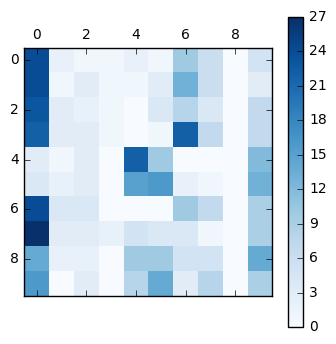

In [34]:
# train model
clf = LogisticRegression(
    random_state=0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=500)

clf.fit(X_train, y_train)

# upload mode and encoder to AWS for prediction
pickle.dump(clf, open('models/gosat_logistic_regression', 'w'))
pickle.dump(encoder, open('models/gosat_logistic_encoder', 'w'))

# train model
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print ("predicted dimensions {0}".format(y_pred.shape))
print ("y test dimensions {0}".format(y_test.shape))

cm = confusion_matrix(y_test, y_pred)

# Plot pixel ranking
plt.matshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [31]:
clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [32]:
# upload mode and encoder to AWS for prediction
pickle.dump(clf, open('models/gosat_logistic_regression', 'w'))
pickle.dump(encoder, open('models/gosat_logistic_encoder', 'w'))

In [33]:
s3 = boto3.client('s3')
s3.upload_file('models/gosat_logistic_regression', 'gosat-models', 'gosat_logistic_regression')
s3.upload_file('models/gosat_logistic_encoder', 'gosat-models', 'gosat_logistic_encoder')

In [43]:
json.dump(zip(clf.classes_, le.inverse_transform(clf.classes_)), open('models/label_mappings.json', 'w'))
s3.upload_file('models/label_mappings.json', 'gosat-models', 'gosat_label_mapping')